In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"
from mpl_toolkits.mplot3d import Axes3D 

from pyipn import copy_template, Universe

[0.         0.53871722]


<IPython.core.display.Javascript object>


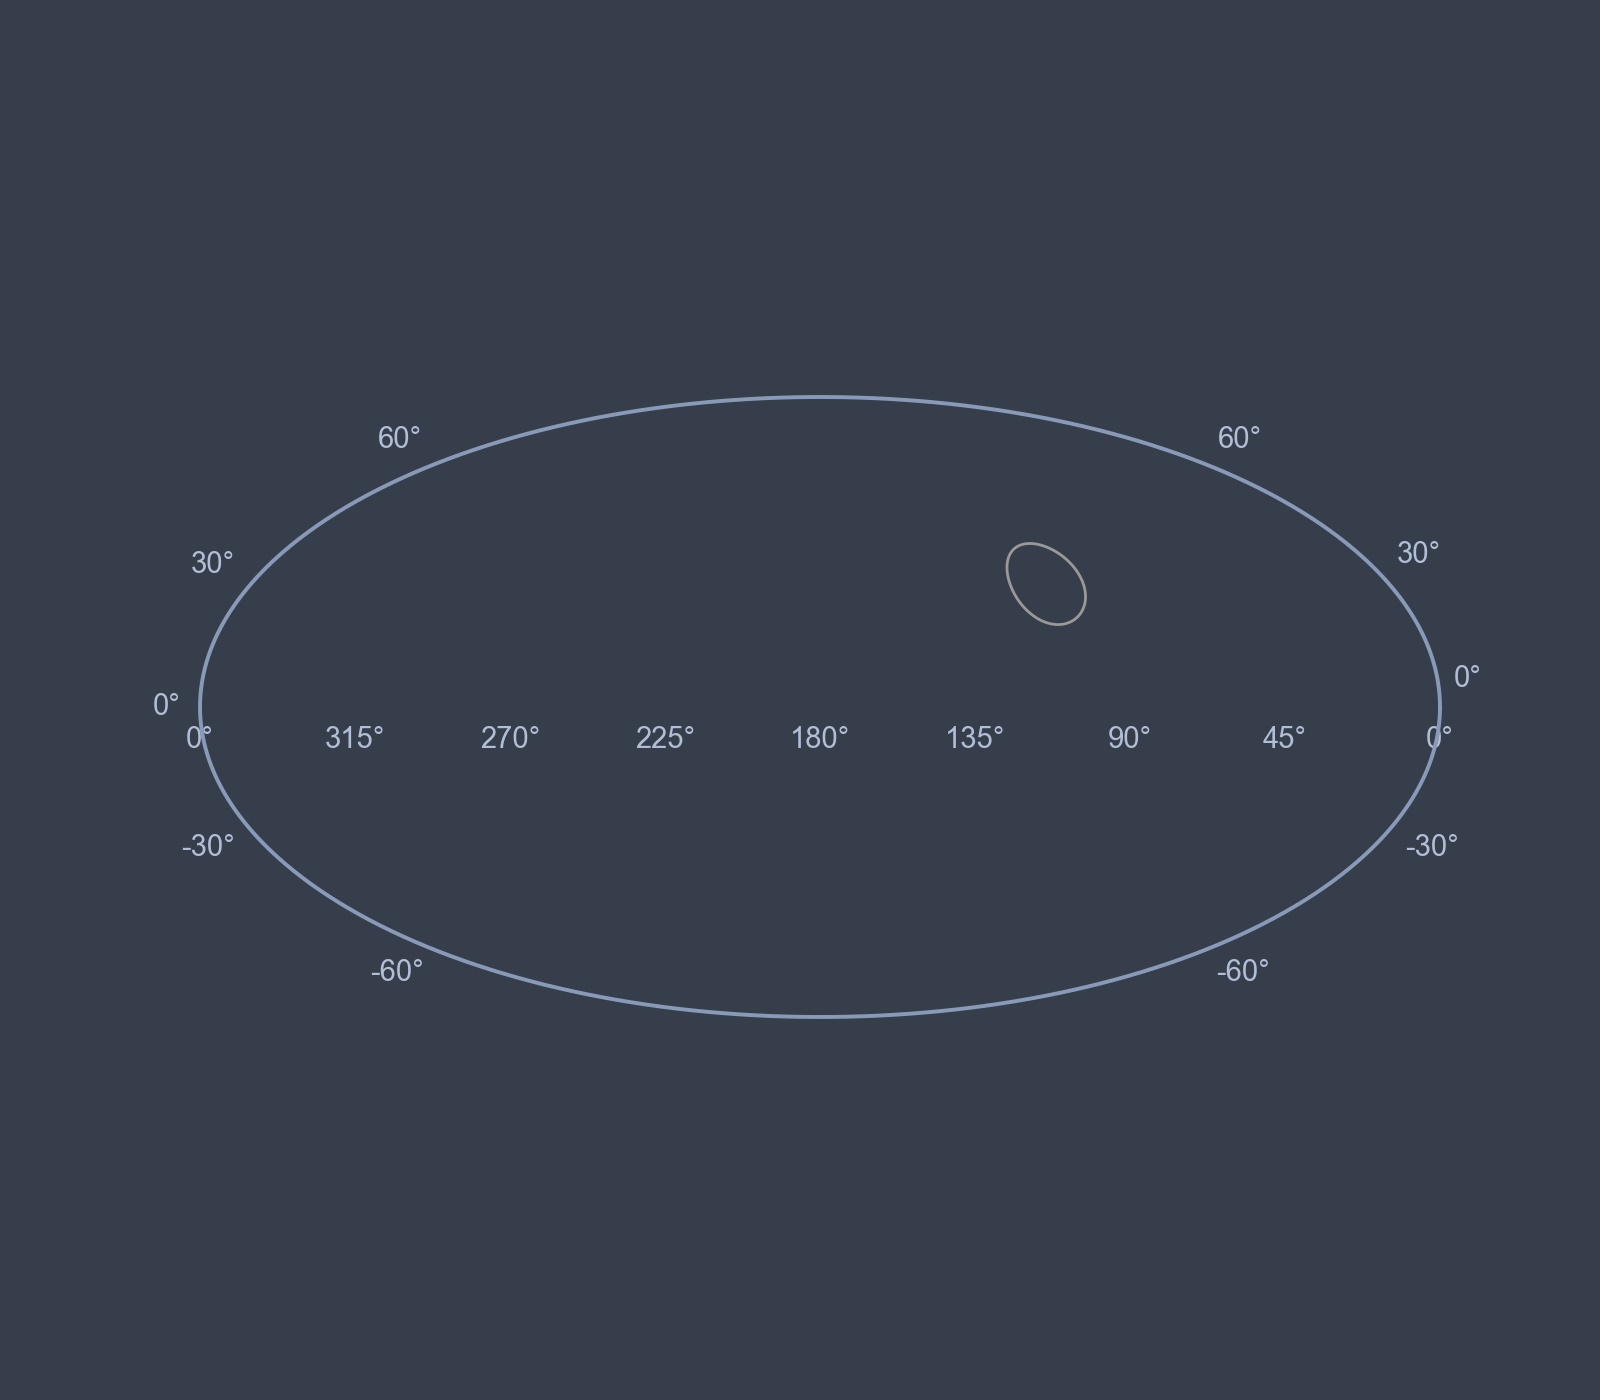

<IPython.core.display.Javascript object>


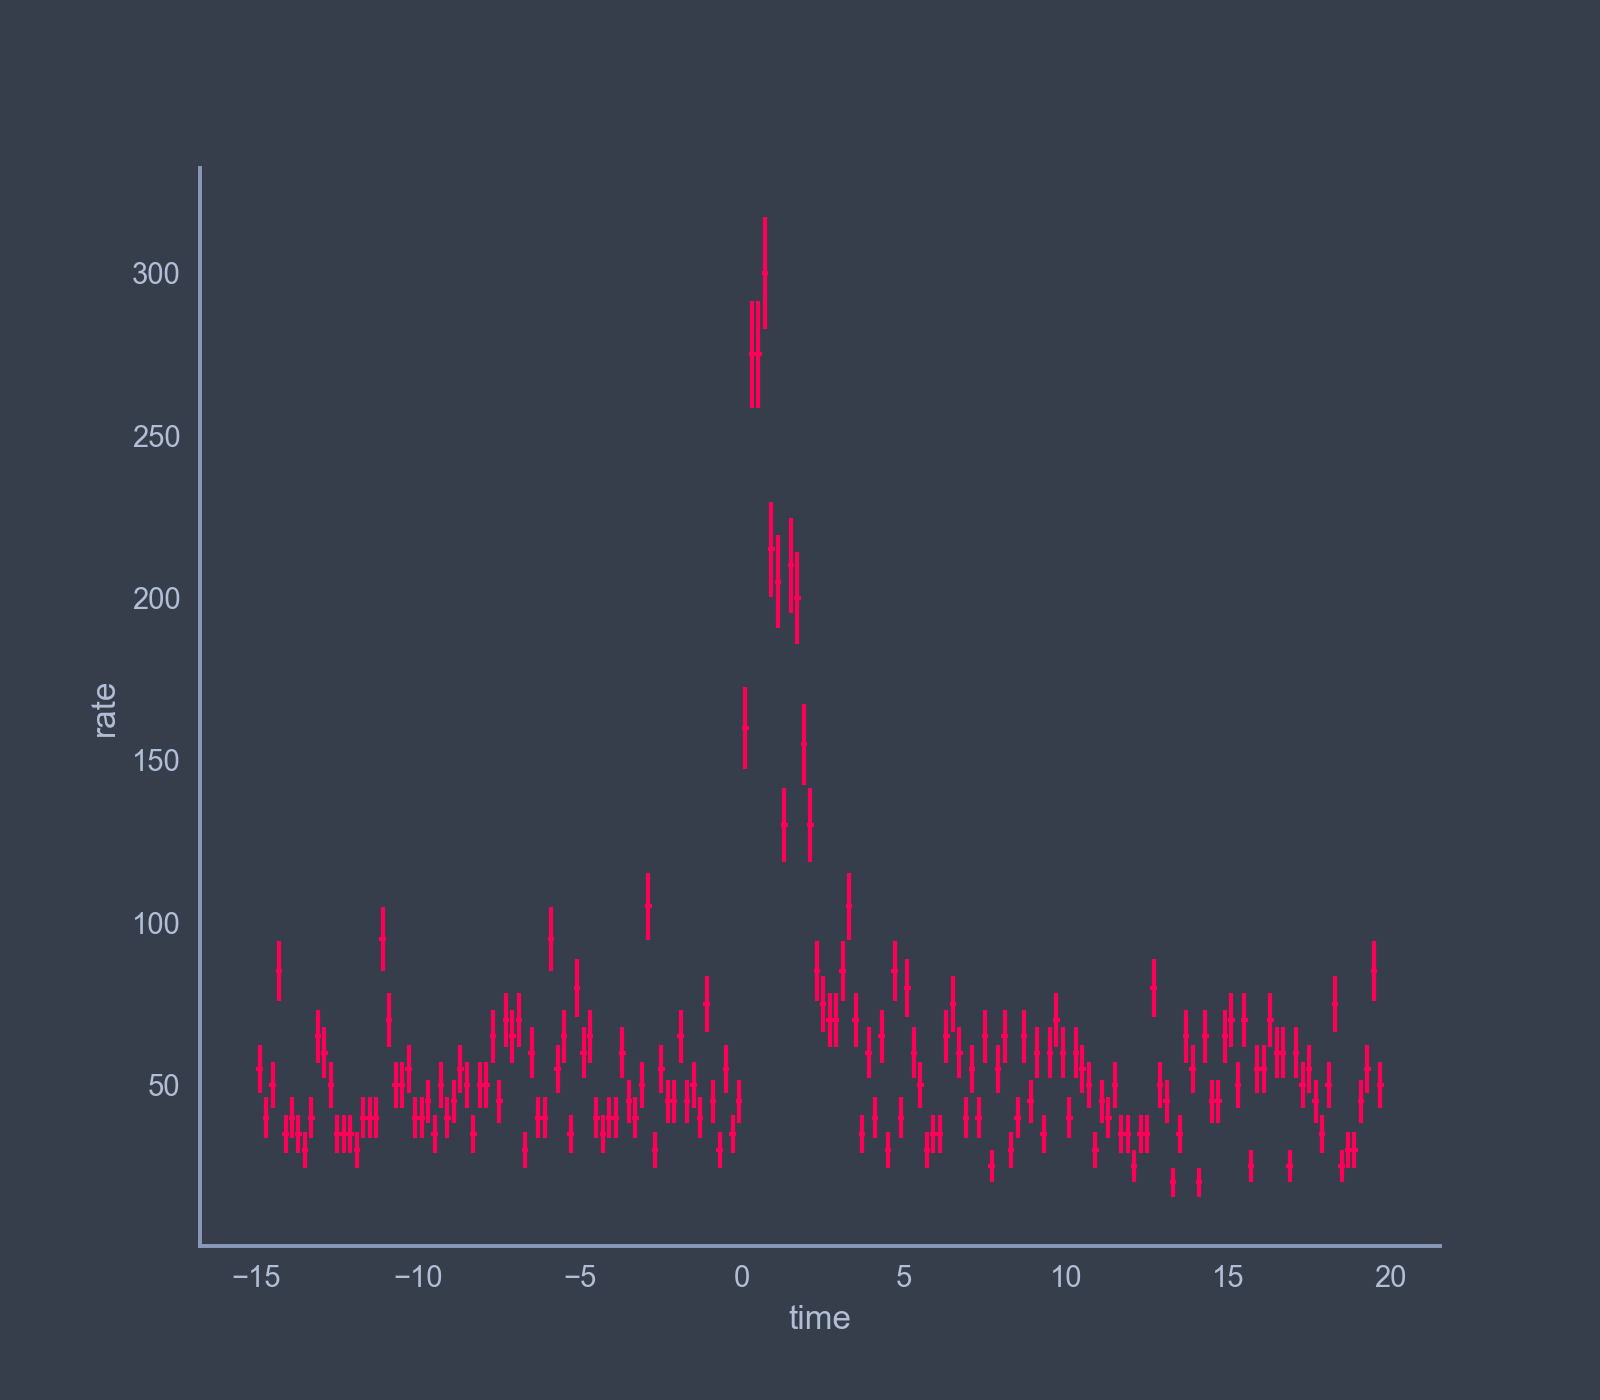

<IPython.core.display.Javascript object>


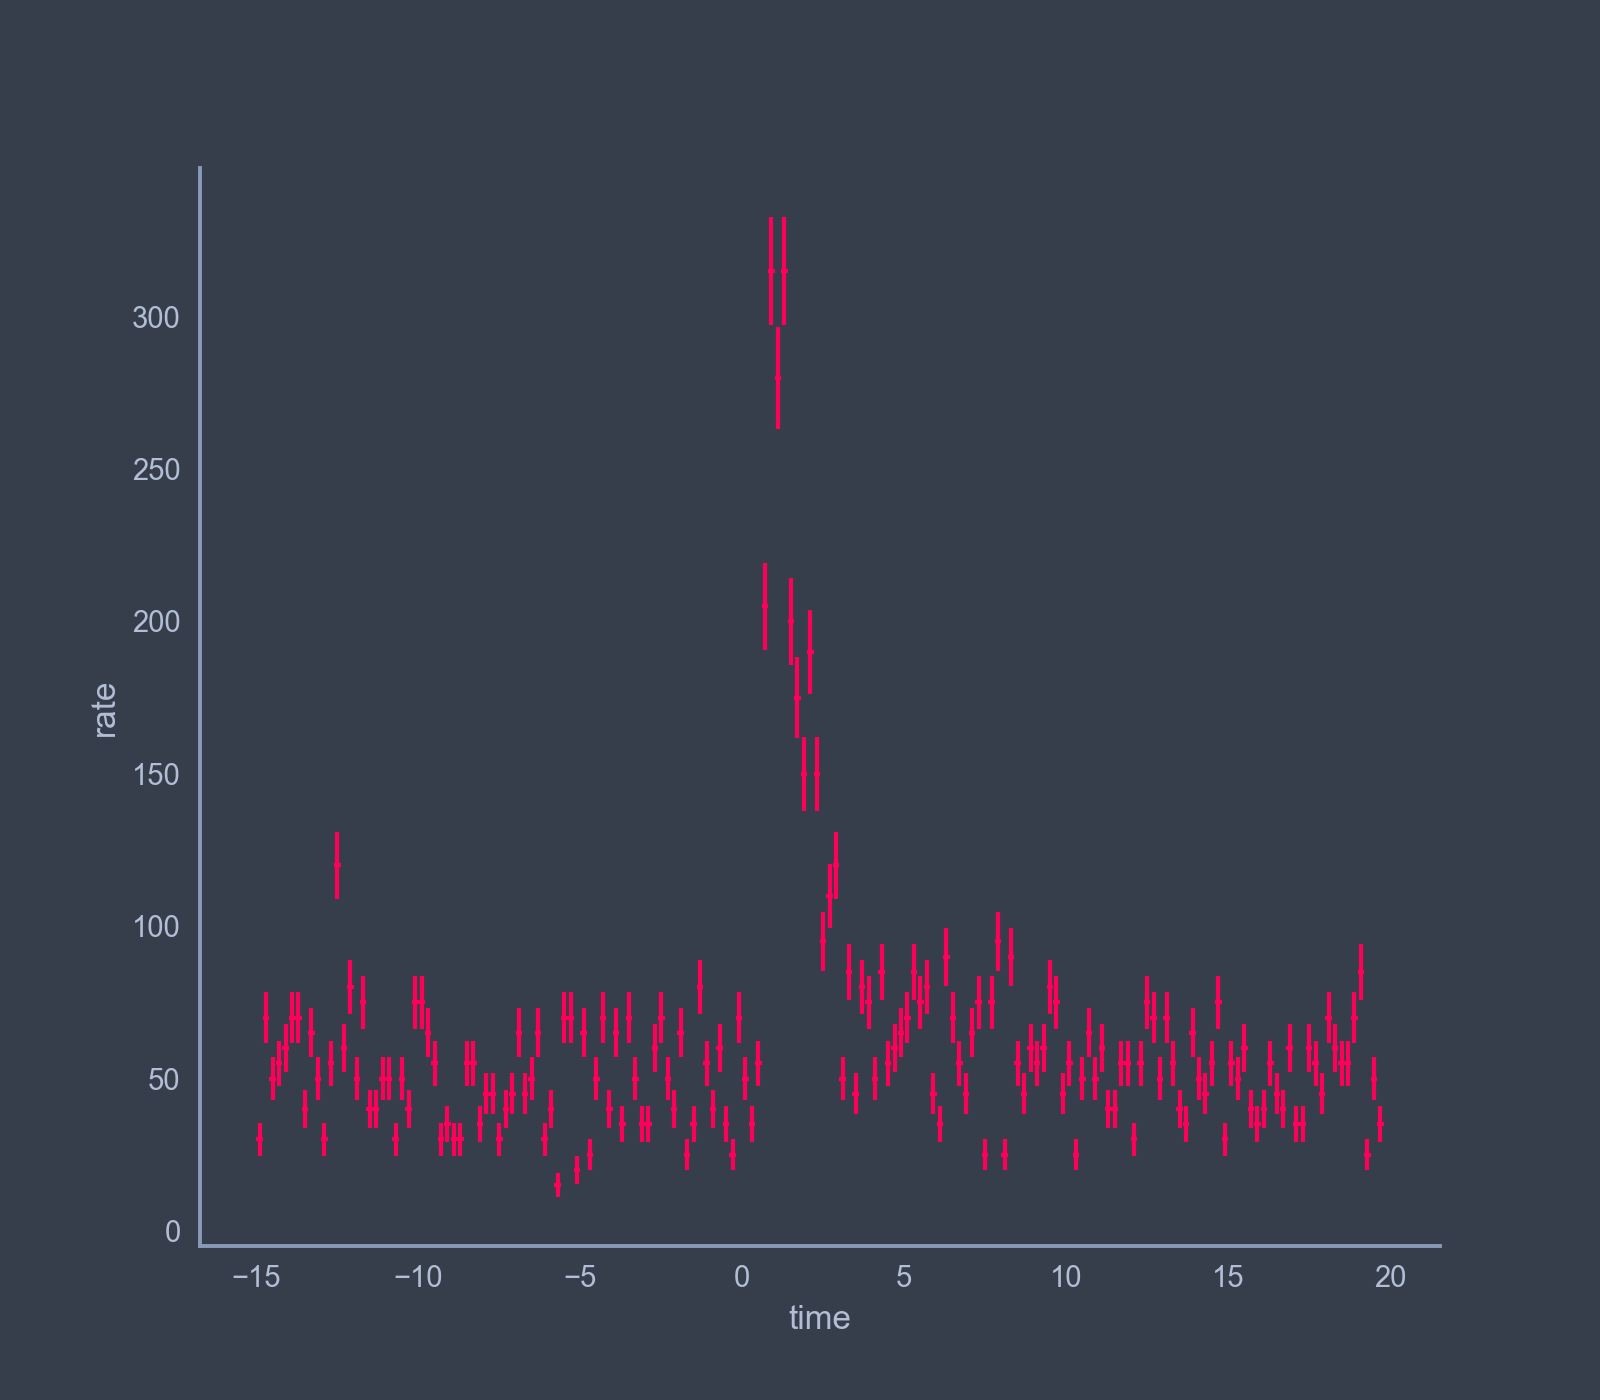

In [14]:

uni = Universe.from_yaml('template_config.yaml')
uni.explode_grb(tstart=-50,tstop=100)
print(uni._T0)
uni.plot_all_annuli(cmap='Set1_r',lw=1);
for det, lc in uni.light_curves.items():

    lc.display(-15,20,.2,color=red)



In [3]:
d1 = uni.detectors['det1']
d2 = uni.detectors['det2']

In [4]:
xyz1=d1.location.get_cartesian_coord().xyz.value

In [5]:
xyz2= d2.location.get_cartesian_coord().xyz.value


In [24]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-20.43,20.4,.2)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-20,20,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=25
k2=25
N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)
omega2=np.random.randn(k2)


data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            k2=k2,
            bw=.7,
            omega=omega,
             omega2=omega2,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
           
           
           
           )

In [13]:
uni._time_differences

array([0.        , 0.53871722])

In [39]:
model = stan_utility.compile_model('rff_loc.stan', model_name='rff')
#model = stan_utility.compile_model('loc_mix.stan', model_name='loc_mix')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_bfeeac4e851887e74798afc5ffe13f62 NOW.


In [40]:
fit = model.sampling(warmup=500,iter=900,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=12, adapt_delta=.8))

<IPython.core.display.Javascript object>


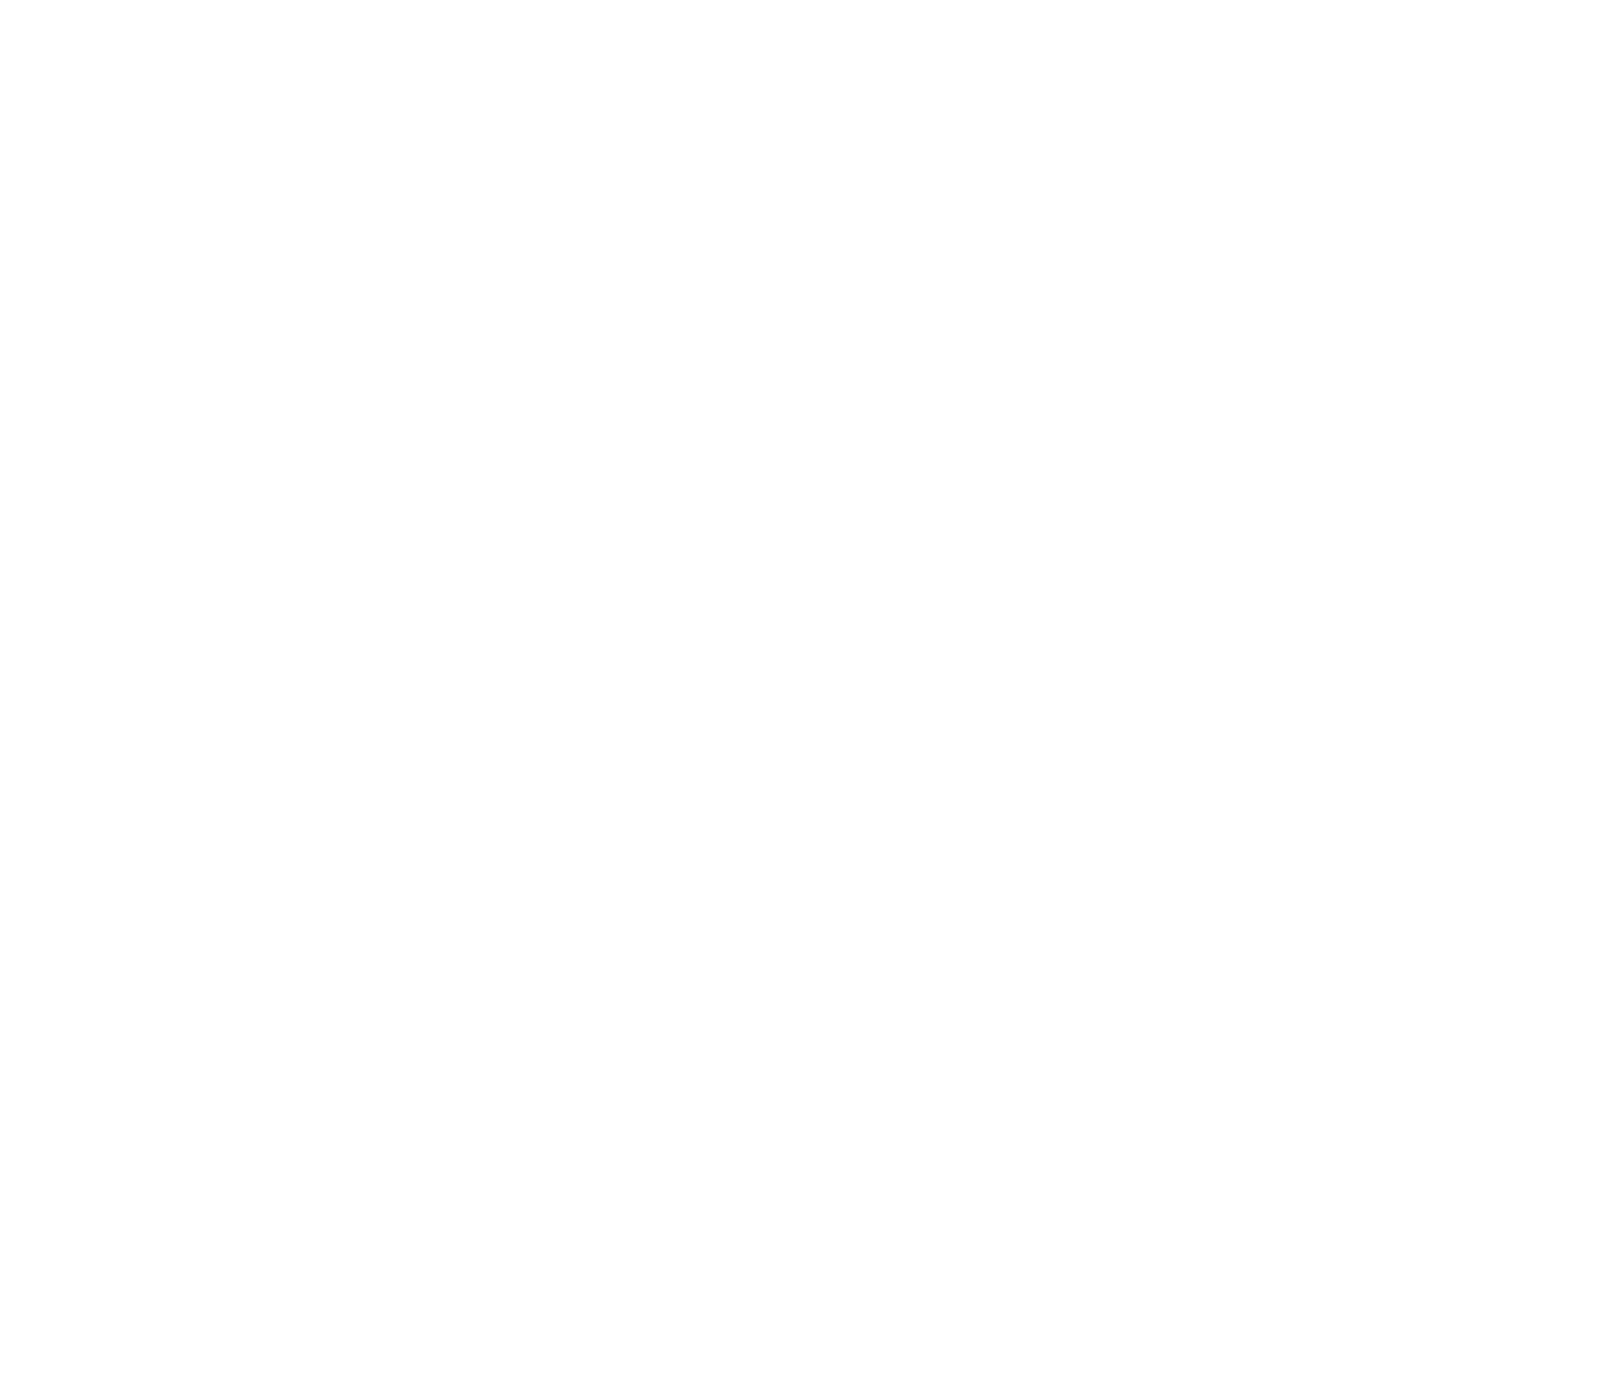

In [41]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt',
              'grb_theta',
              'grb_phi',
              
              'log_amplitude1',
               'log_amplitude2',
            #  'tstart',
         #     'tstop'
             
             ]);

In [ ]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


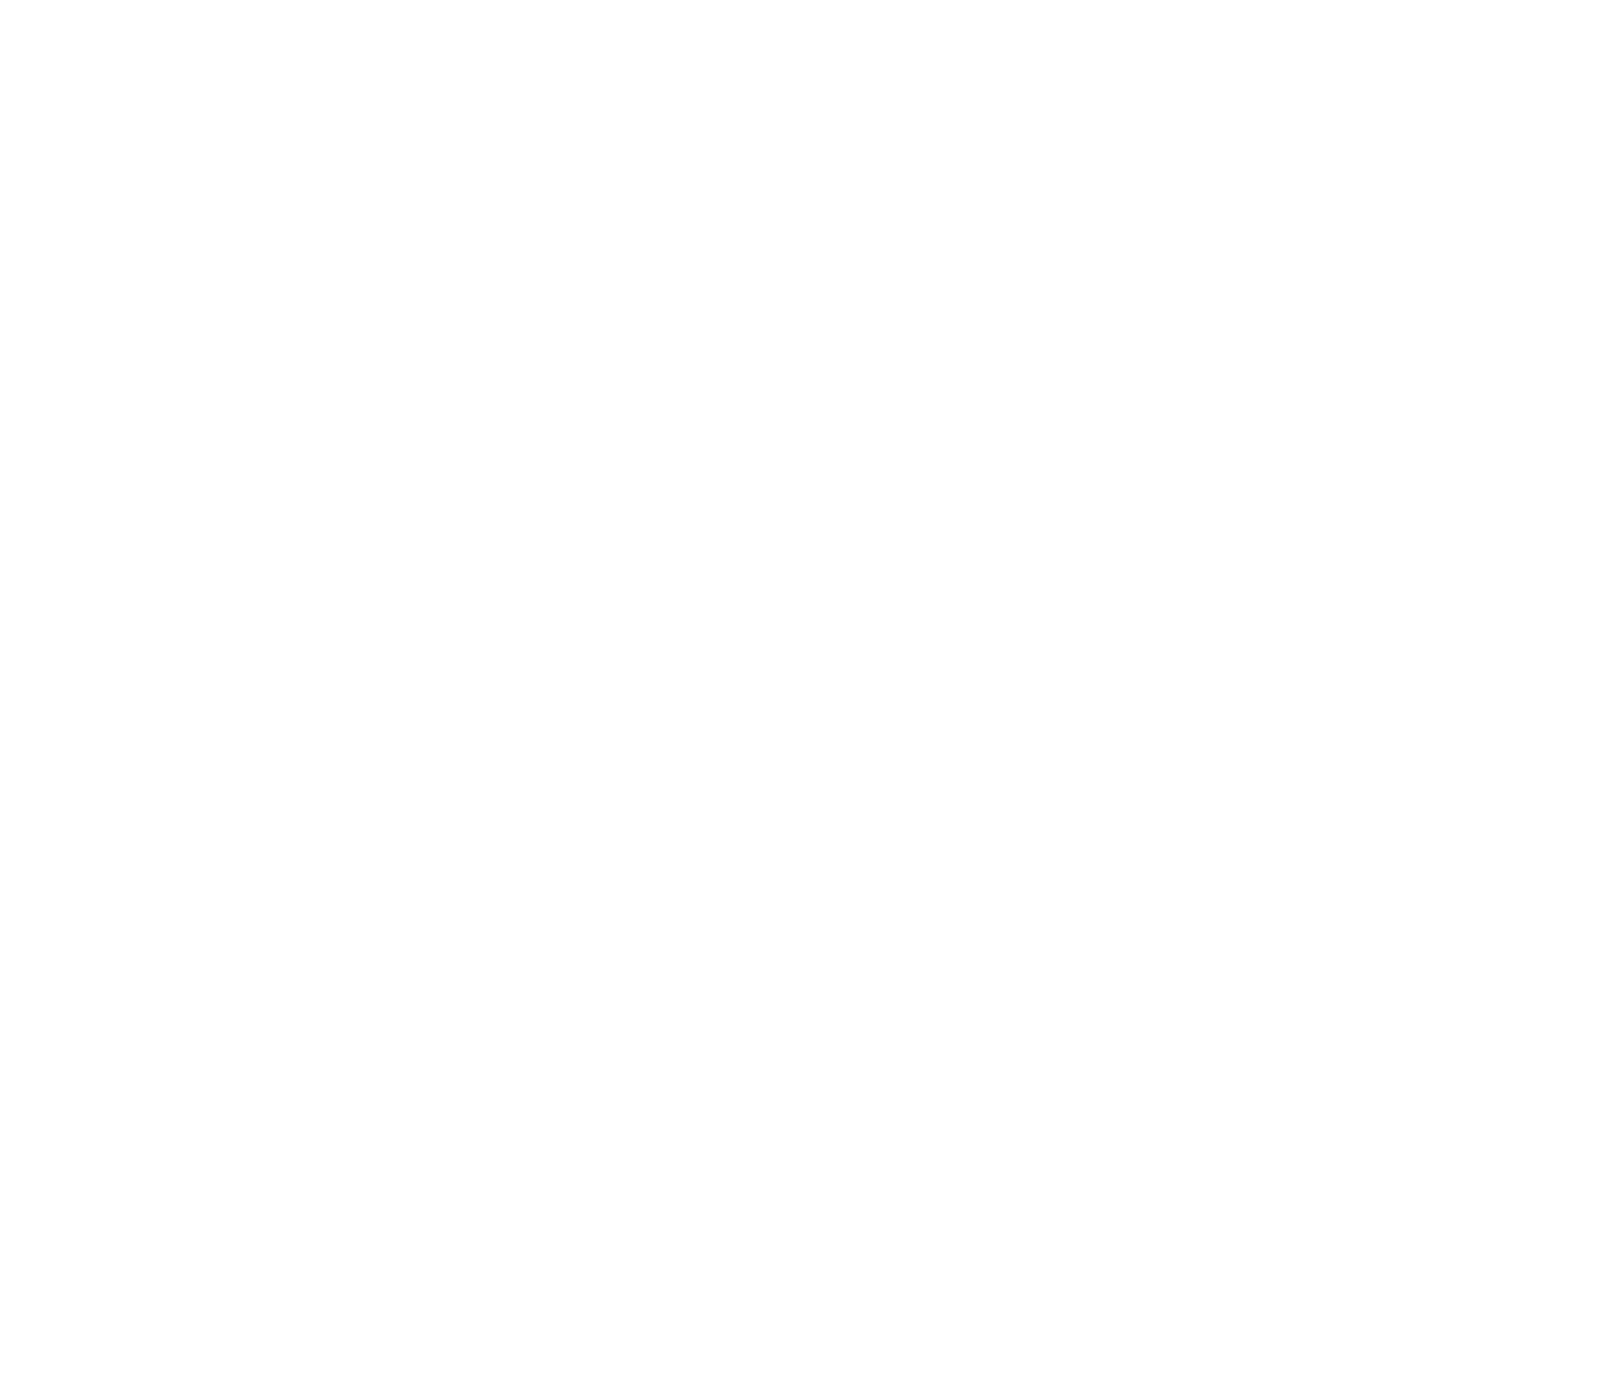

In [42]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


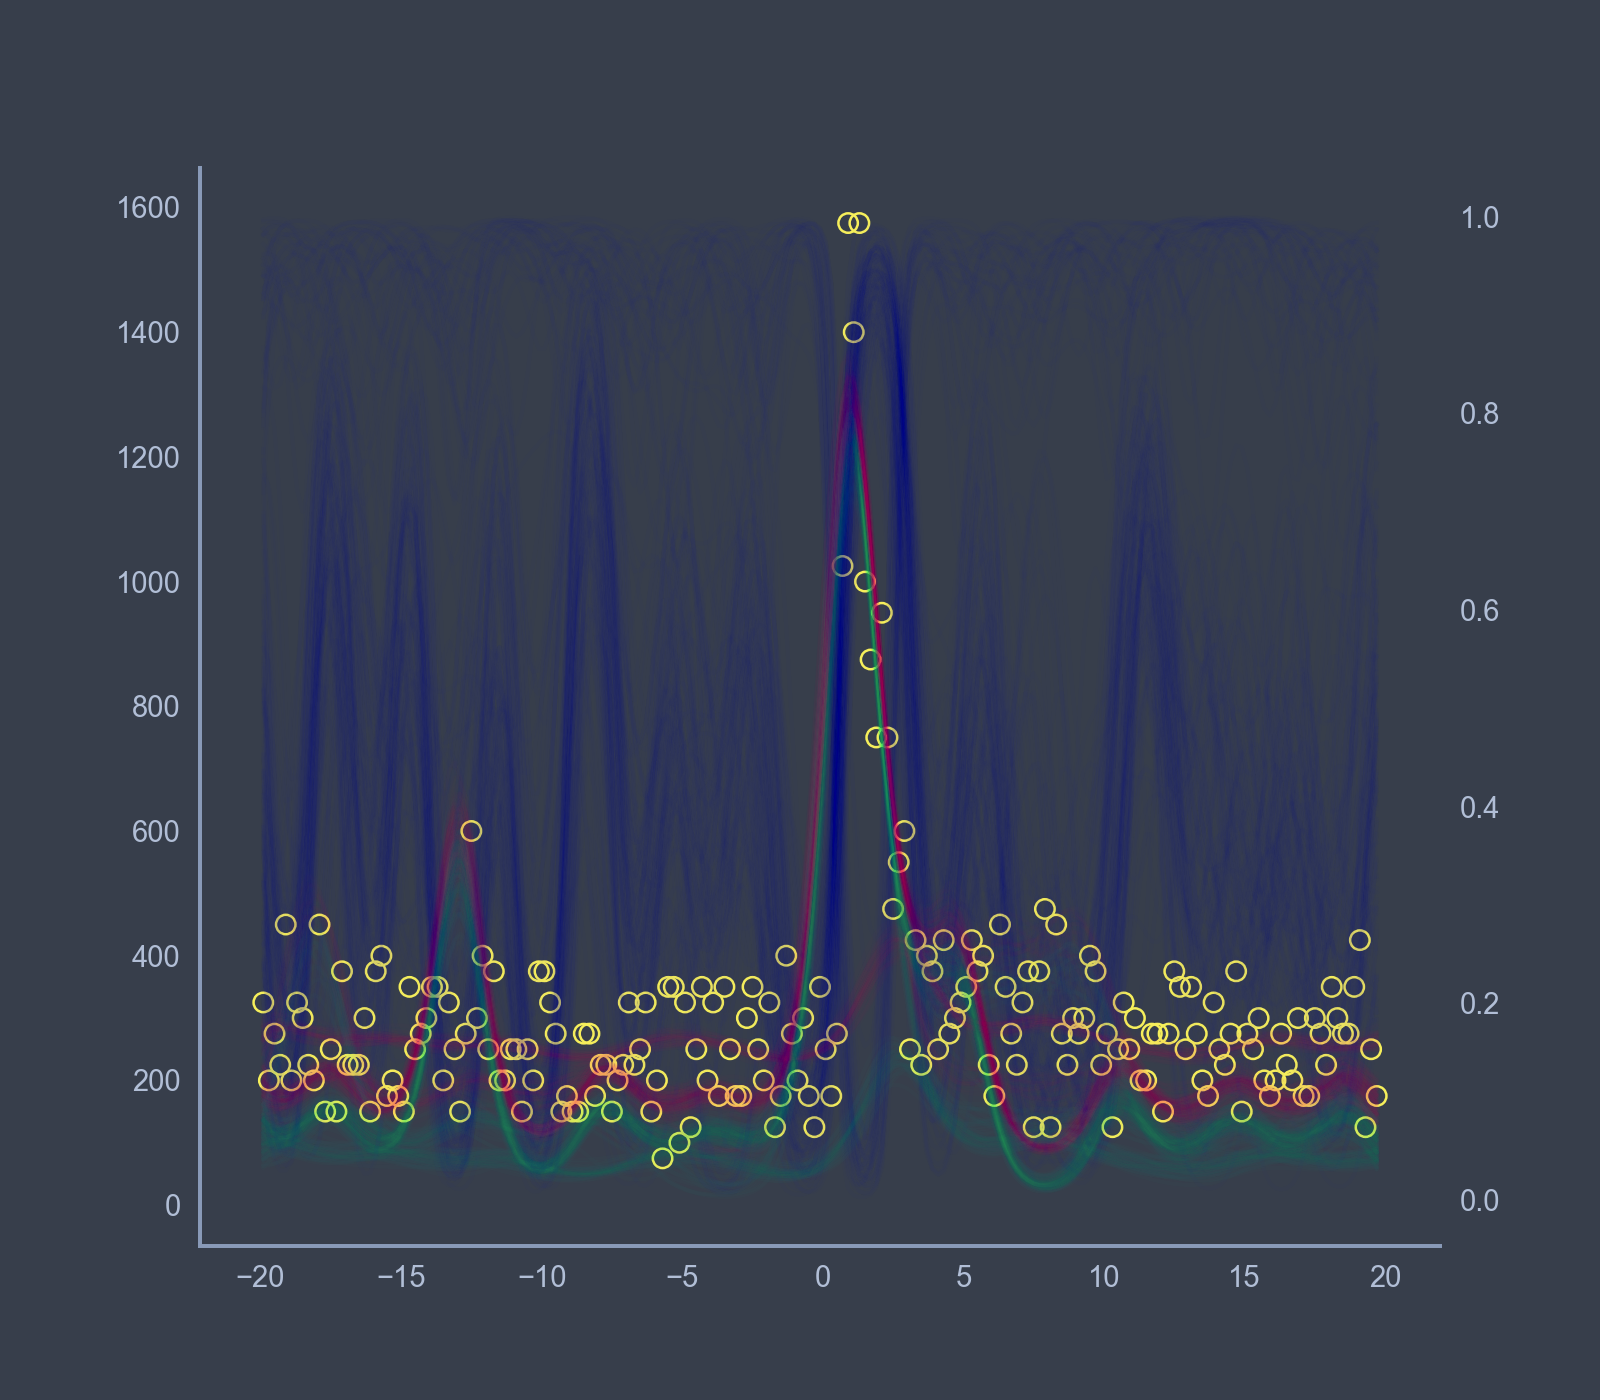

In [32]:
fig, ax = plt.subplots()

ax2 = ax.twinx()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']
window =  fit.extract('grb_window2')['grb_window2']


for y, b, w in zip(fhat[::10], bkg[::10], window[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
    ax2.plot(mid2,w, alpha=0.01, color='blue')
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


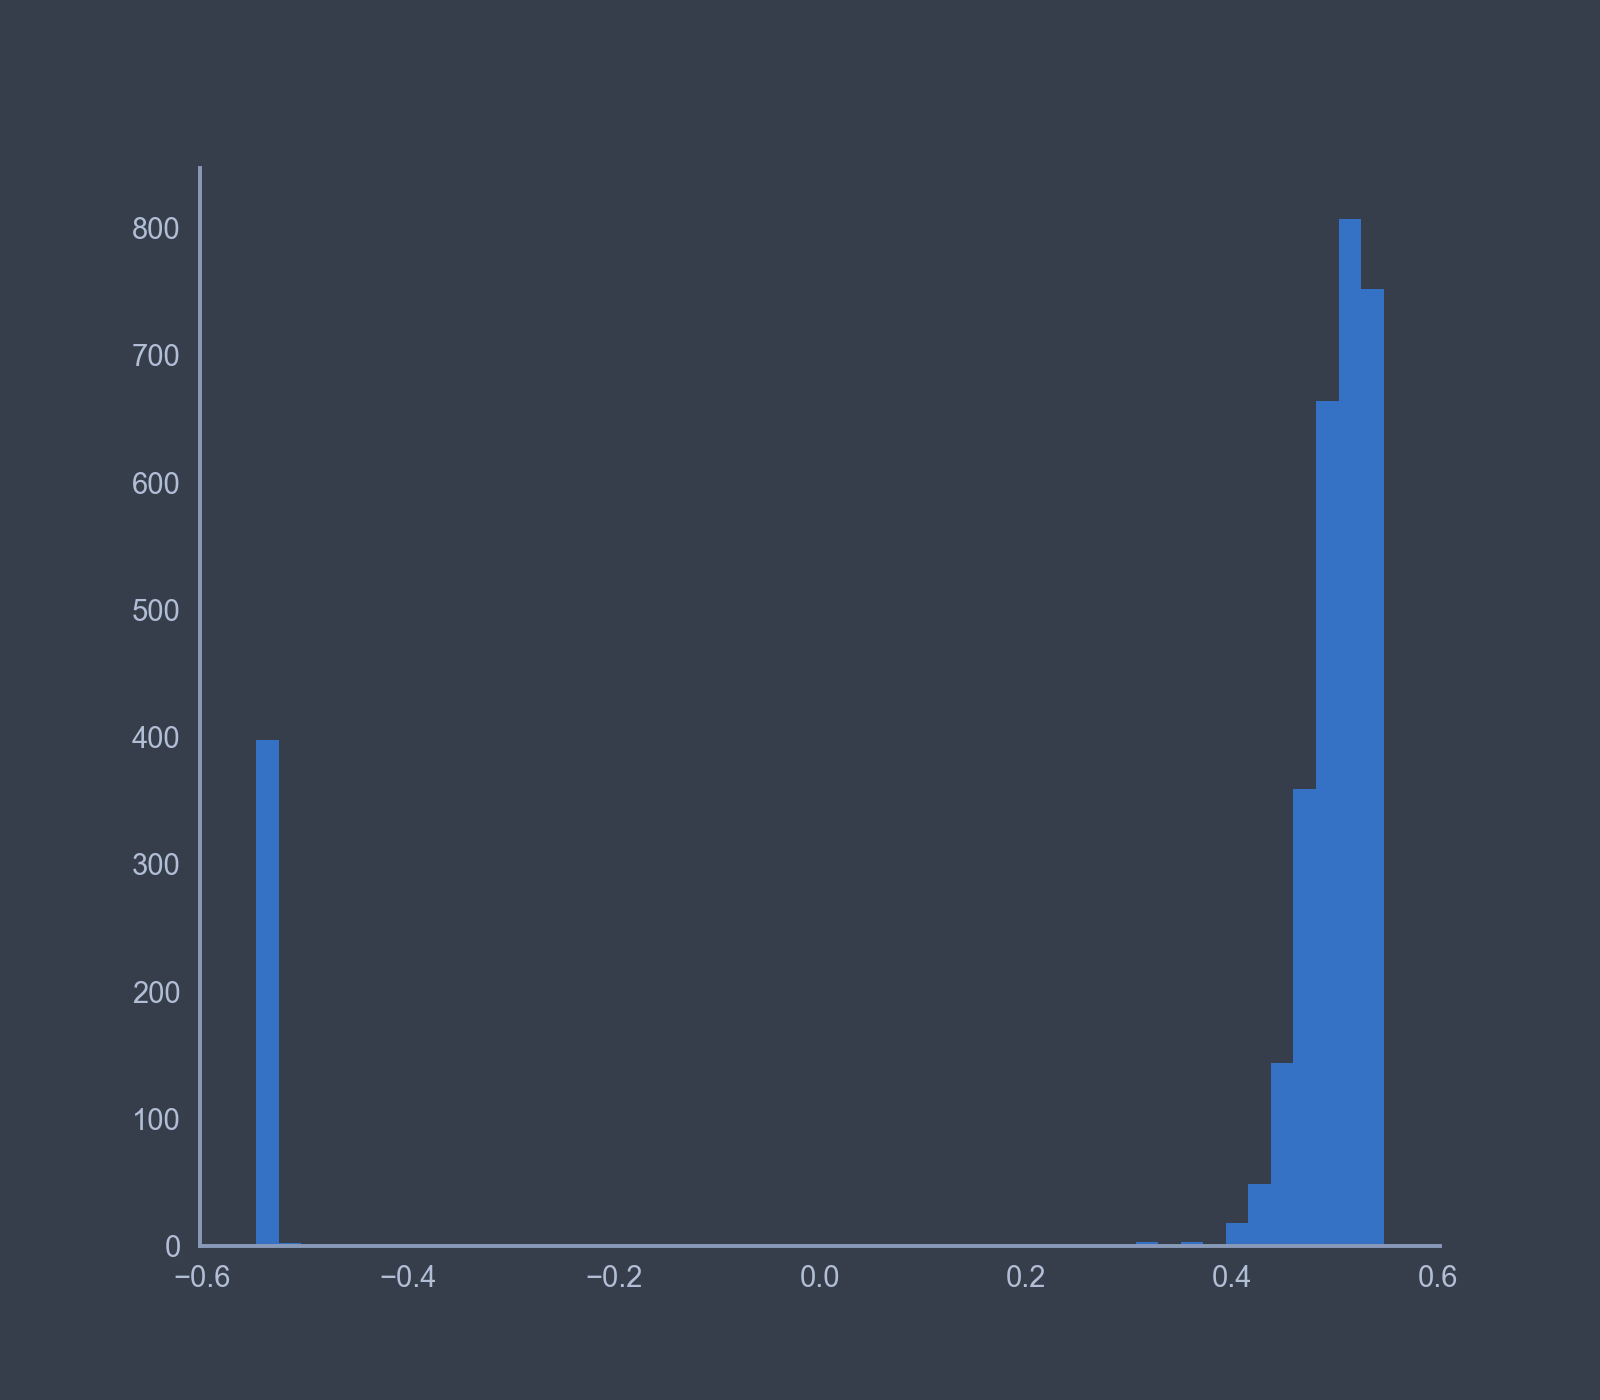

(array([398.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   3.,   1.,  18.,
         49., 144., 359., 664., 807., 752.]),
 array([-5.47171256e-01, -5.25285320e-01, -5.03399385e-01, -4.81513449e-01,
        -4.59627513e-01, -4.37741577e-01, -4.15855642e-01, -3.93969706e-01,
        -3.72083770e-01, -3.50197834e-01, -3.28311898e-01, -3.06425963e-01,
        -2.84540027e-01, -2.62654091e-01, -2.40768155e-01, -2.18882219e-01,
        -1.96996284e-01, -1.75110348e-01, -1.53224412e-01, -1.31338476e-01,
        -1.09452541e-01, -8.75666048e-02, -6.56806690e-02, -4.37947333e-02,
        -2.19087975e-02, -2.28617050e-05,  2.18630741e-02,  4.37490099e-02,
         6.56349456e-02,  8.75208814e-02,  1.09406817e-01,  1.31292753e-01,
         1.53178689e-01,  1.75064625e-01,  1.96950

In [38]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

In [ ]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

In [ ]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


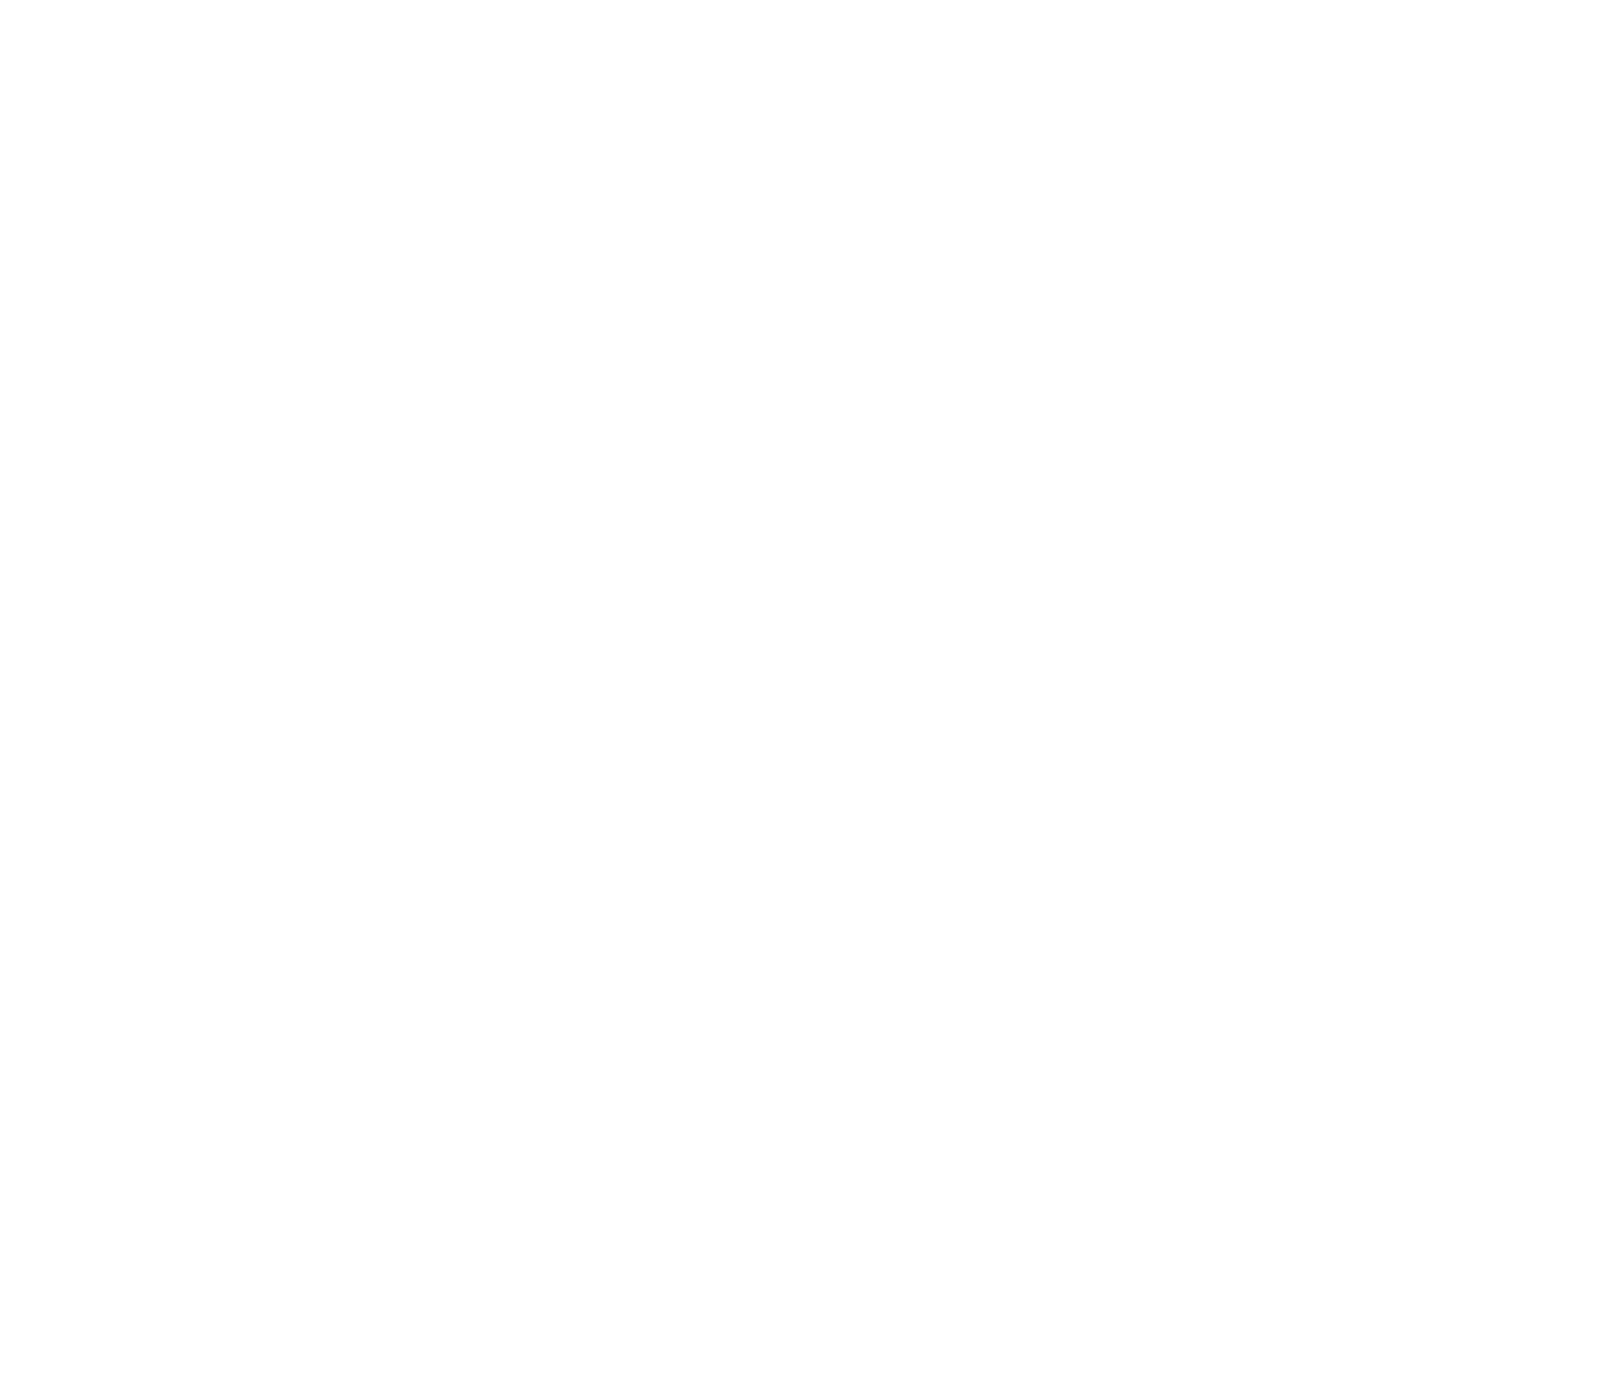

In [43]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(105,20,unit='deg') ))

theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta, c=green, alpha=.1,transform=ax.get_transform("icrs"),s=20)
ax.scatter(np.array([105.]),np.array([20.]),c=red, s=40,transform=ax.get_transform("icrs"))



<IPython.core.display.Javascript object>


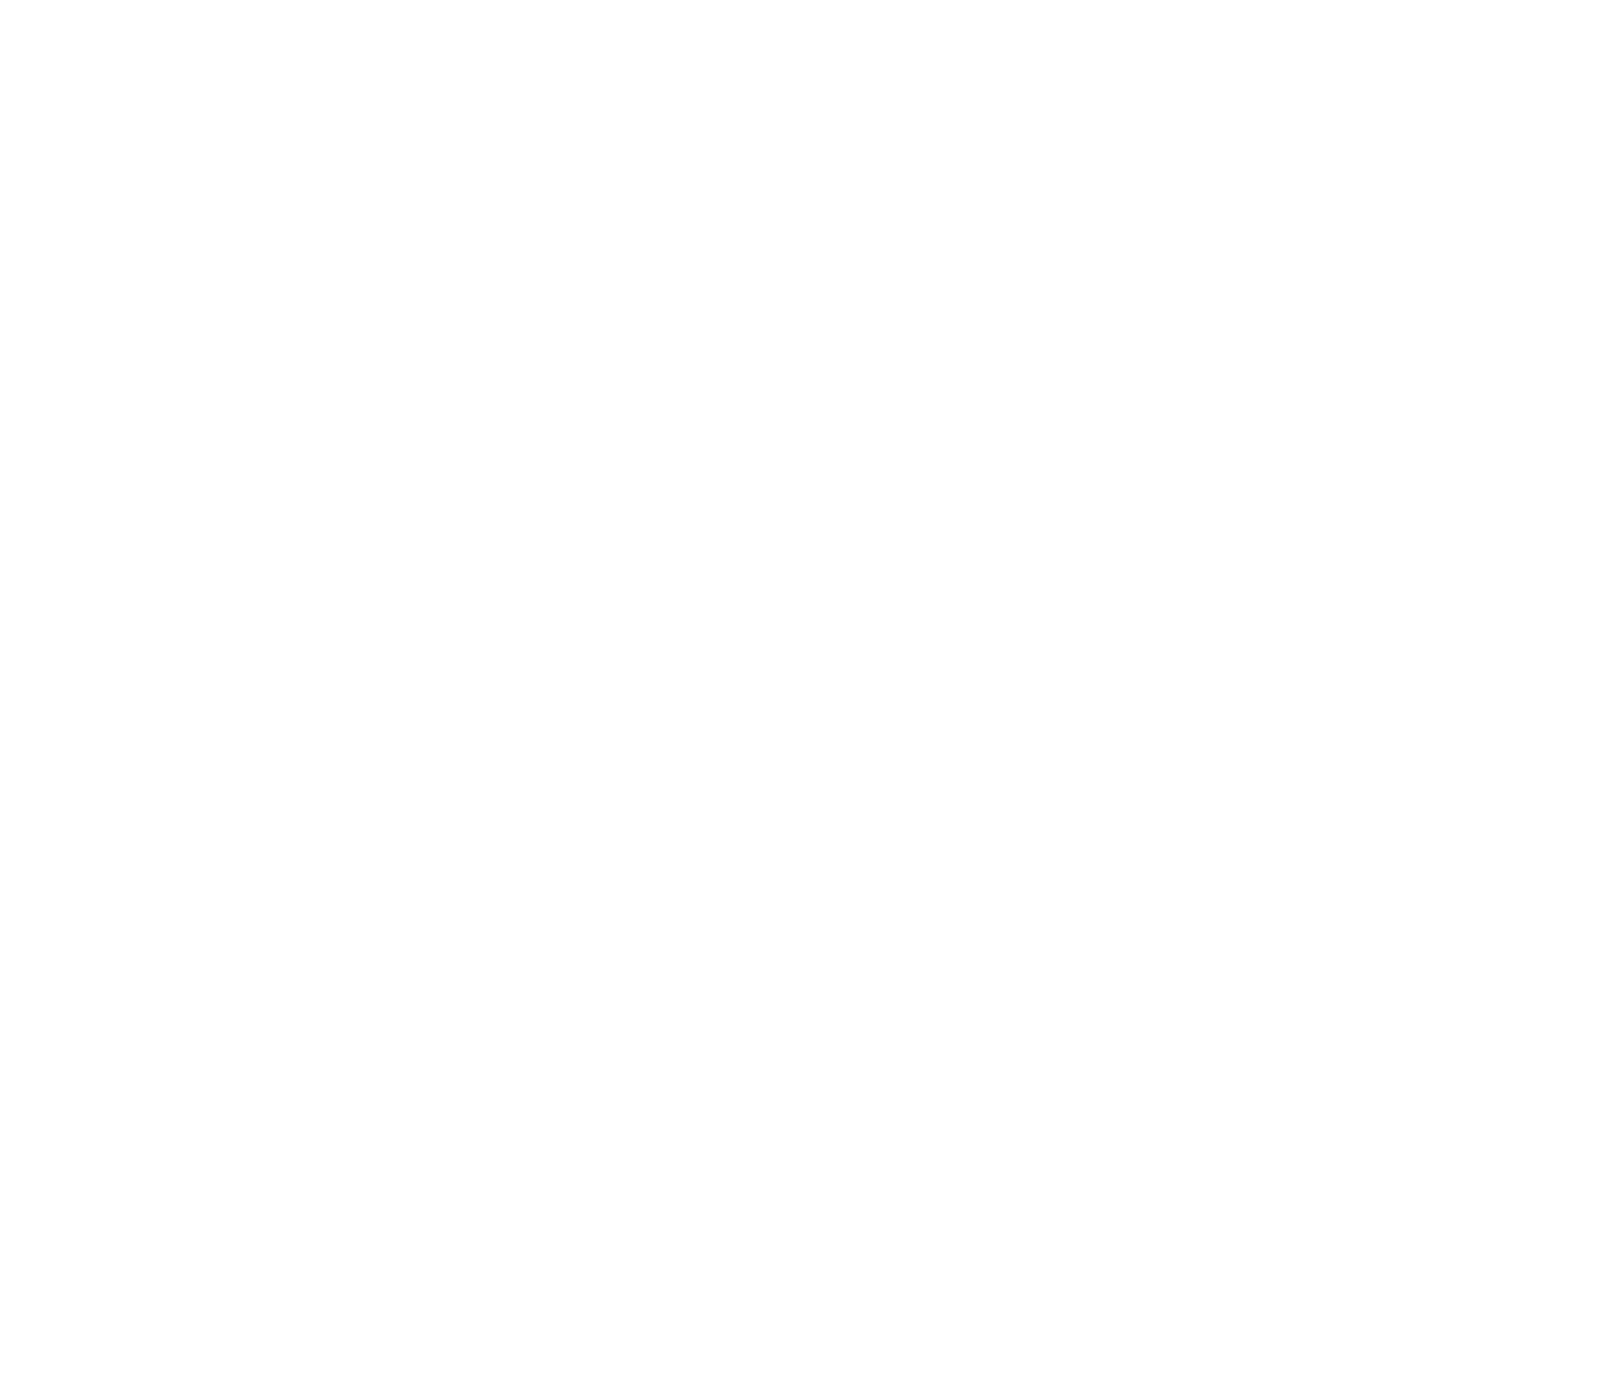

In [44]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
xyz = fit.extract('grb_xyz')['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.05)
u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False



In [35]:

def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

<IPython.core.display.Javascript object>


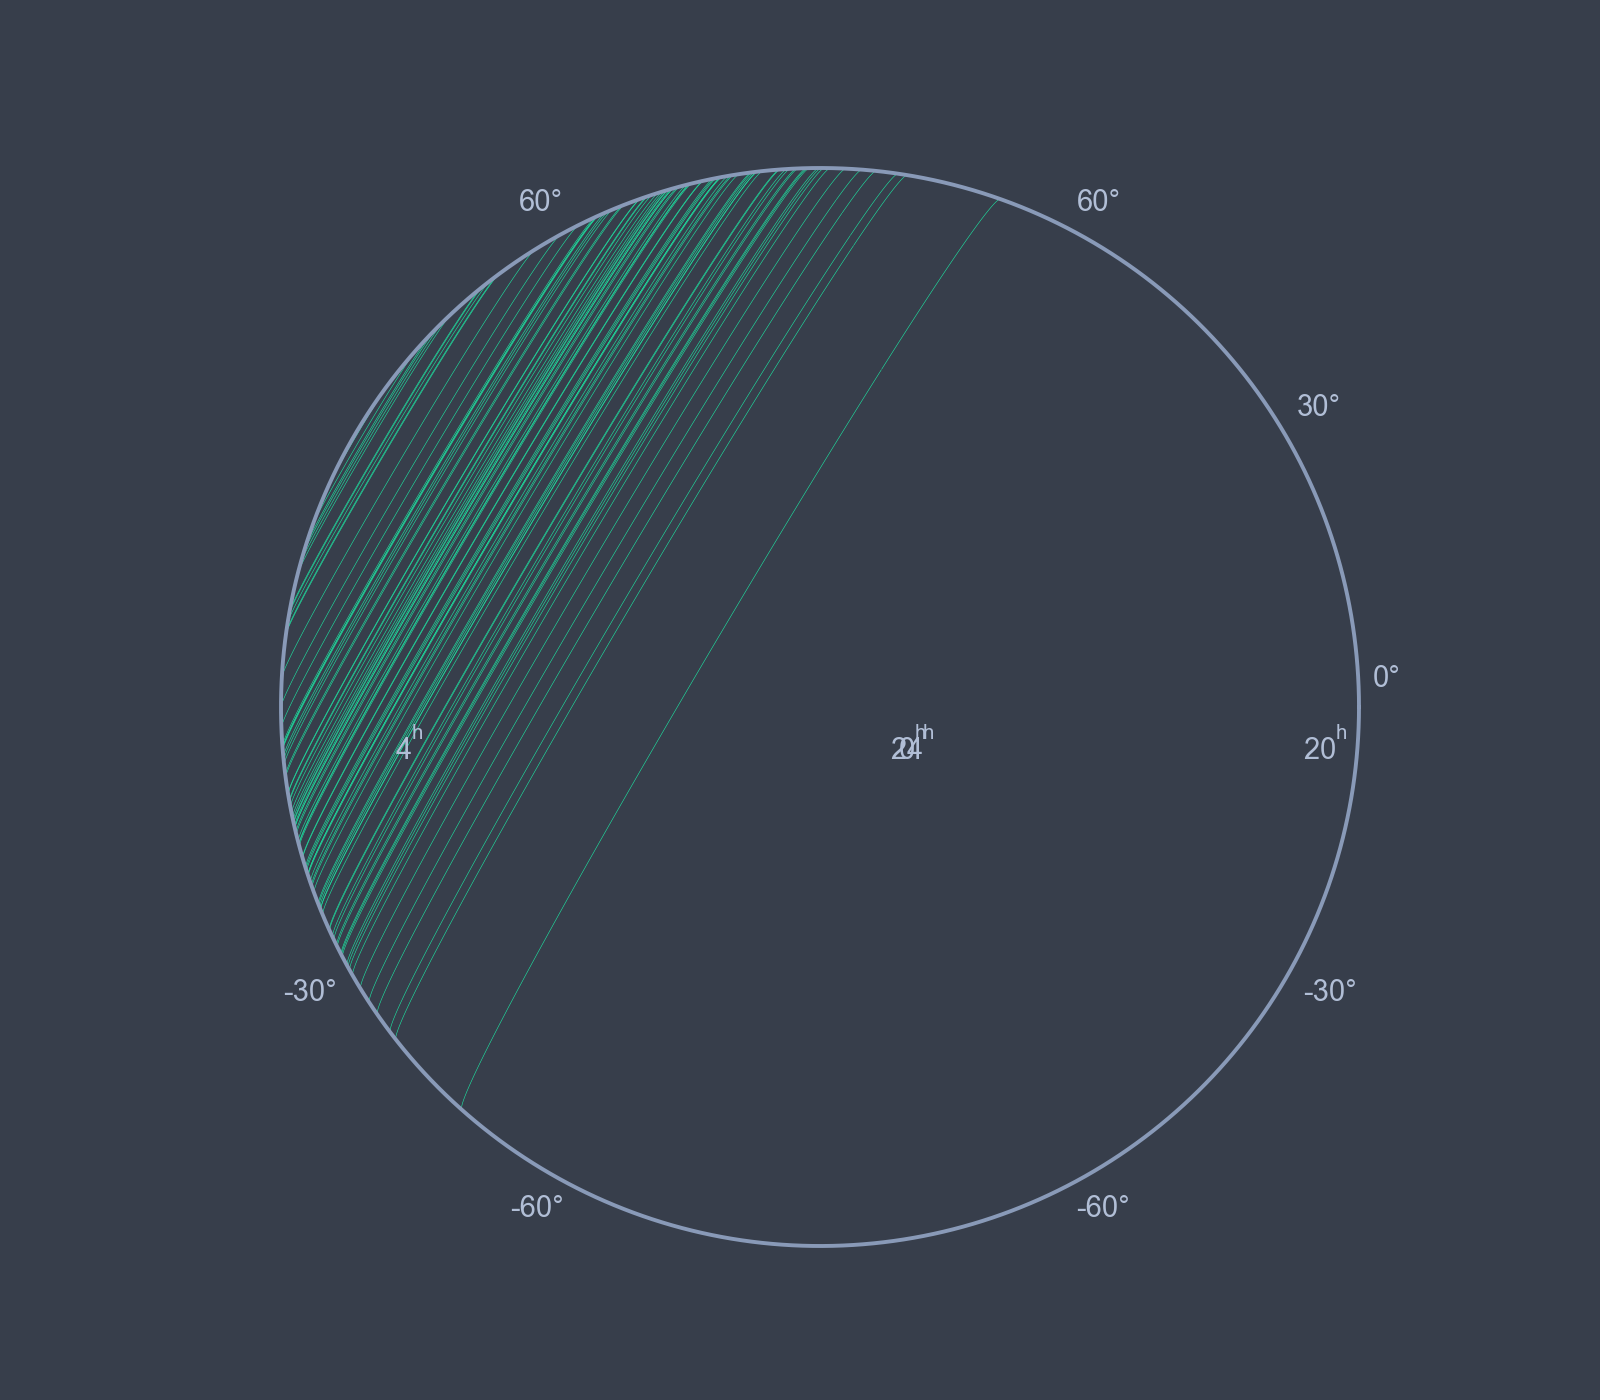

In [36]:

dt = fit.extract('dt')['dt']
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(10, 10,unit='deg') ))
for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
    
    
ax.scatter(np.array([105.]),np.array([20.]),c=red, s=40,transform=ax.get_transform("icrs"))



In [ ]:
fig2 = uni.plot_all_annuli(lw=3);


ax2 = fig2.get_axes()[0]
ax2.scatter(np.array([1.]),np.array([10.]),c=yellow, s=40,
            transform=ax.get_transform("icrs")
           )


for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax2 )
    
    


In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(1.9, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

In [ ]:
uni._T0